In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import matplotlib
import wandb
import torch.nn as nn
import torchvision.transforms as tform
import torch.optim as optim
import aslxplane.perception.models as xplane_models
from torch.utils.data import Dataset, DataLoader
from tqdm import trange, tqdm
from PIL import Image
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'
%autoreload 2

## Setup

In [3]:
# data_dir = "../Xplane-data-dir/conformal-shifts-data/sinusoids-12-09-22/"
data_dir = "../../Xplane-data-dir/uli-datasets/morning/morning_train/"
label_file = "labels.csv"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load label file and plot some dataset statistics

In [4]:
df = pd.read_csv(data_dir + label_file)
df[:5]

,image_filename,absolute_time_GMT_seconds,relative_time_seconds,distance_to_centerline_meters,distance_to_centerline_NORMALIZED,downtrack_position_meters,downtrack_position_NORMALIZED,heading_error_degrees,heading_error_NORMALIZED,period_of_day,cloud_type
0,MWH_Runway04_morning_clear_1_0.png,63202.285156,0.000000,-3.439417,-0.343942,46.564592,0.015615,-6.435067,-0.214502,0,0
1,MWH_Runway04_morning_clear_1_1.png,63202.503906,0.218750,-3.584151,-0.358415,47.931997,0.016074,-6.442467,-0.214749,0,0
2,MWH_Runway04_morning_clear_1_2.png,63202.726562,0.441406,-3.715966,-0.371597,49.207705,0.016502,-6.454793,-0.215160,0,0
3,MWH_Runway04_morning_clear_1_3.png,63202.964844,0.679688,-3.870111,-0.387011,50.722217,0.017009,-6.472939,-0.215765,0,0
4,MWH_Runway04_morning_clear_1_4.png,63203.187500,0.902344,-4.002168,-0.400217,52.004963,0.017440,-6.489053,-0.216302,0,0


Text(0.5, 1.0, 'distribution of tracking errors')

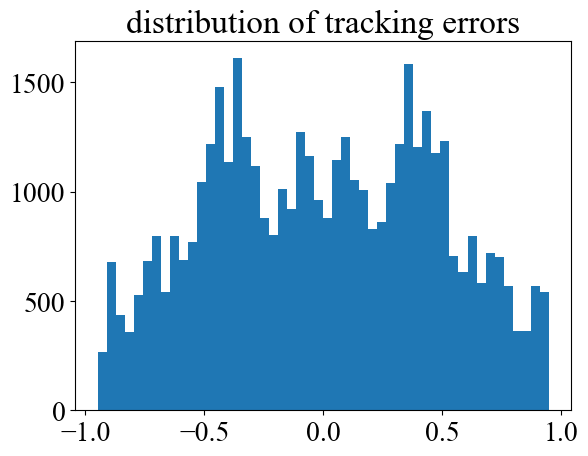

In [5]:
plt.hist(df.loc[:,"distance_to_centerline_NORMALIZED"],bins=50)
plt.title("distribution of tracking errors")

## Set Model Architecture
- do this first because the input size determines how much to downsample by in the dataloader

In [6]:
model_params = {
    "type": "encoder",
    "image_size": (128,256),
    "hidden_layers": (128, 64)
}

# Construct Dataset/Dataloader and plot example

In [7]:
class TaxiNet(Dataset):

    def __init__(self, df, data_dir, label_file, image_size):
        self.data_dir = data_dir
        self.label_file = label_file
        self.df = df
        self.morning_images = df.index[df["image_filename"].str.contains("morning")].to_list()
        self.resize_and_grayscale = tform.Compose([
            tform.Resize(size=image_size),
            tform.Grayscale(),
            tform.ToTensor()
        ])
        
    def __len__(self):
        return len(self.morning_images)

    def __getitem__(self, idx):
        data_idx = self.morning_images[idx]
        img_file = df.loc[data_idx, "image_filename"]
        y_cte = df.loc[data_idx, "distance_to_centerline_NORMALIZED"]
        y_he = df.loc[data_idx, "heading_error_NORMALIZED"]
        img = Image.open(data_dir + img_file)
        return torch.tensor([y_cte, y_he]), self.resize_and_grayscale(img)

In [8]:
dataset = TaxiNet(df, data_dir, label_file, model_params["image_size"])

dataset contains 44786 points


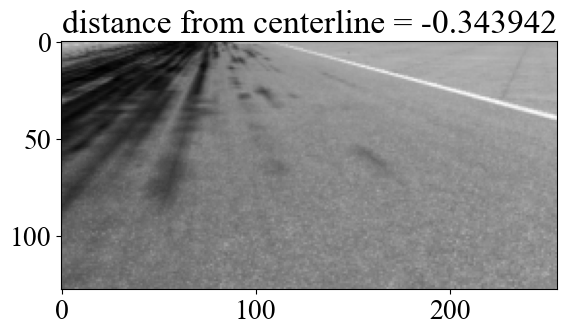

In [9]:
y, img = dataset[0]
plt.imshow(tform.ToPILImage()(img), cmap="gray")
plt.title(f"distance from centerline = {y[0]}")
print("dataset contains %d points" % len(dataset))

## Setup Training


In [10]:
train_split = int(.8 * len(dataset))
val_split = len(dataset) - train_split
train_data, val_data = torch.utils.data.random_split(dataset, [train_split, val_split])

In [11]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32)

In [13]:
if model_params["type"] == "encoder":
    encoder = xplane_models.get_encoder(model_params).to(device)
else:
    pass

In [14]:
learning_params = {"num_epochs": 10, 
                   "num_train_steps":3000, 
                   "learning_rate":1e-2, 
                   "compute_val":500
                   }

optimizer = optim.Adam(encoder.parameters(),
                    lr=learning_params["learning_rate"],
                    weight_decay=1e-3)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                                        lambda i: learning_params["learning_rate"] if i < 6 else .1 * learning_params["learning_rate"]
                                        )

In [15]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="asl-closed-loop-monitor",
    
    # track hyperparameters and run metadata
    config={
    "architecture": "MLP",
    "dataset": data_dir.split("/")[-2],
    "output": "cte_and_he"
    }
)

wandb: Currently logged in as: rhnsinha (asl-closed-loop-monitor). Use `wandb login --relogin` to force relogin


In [15]:
def get_loss(model, X, y, loss_func):
    pred = model(X.to(device))
    loss = loss_func(pred, y.float().to(device))
    return loss

def train(encoder, optimizer, train_data, val_data, scheduler, learning_params=None):
    train_losses = []
    val_losses = [-1]
    epochs = trange(learning_params["num_epochs"], desc='Current Loss = ', leave=True)
    loss_func = nn.MSELoss()
    for i in epochs:
        for j, (y, X) in enumerate(train_data):
            if j > learning_params["num_train_steps"]:
                break
            optimizer.zero_grad()
        
            loss = get_loss(encoder, X, y, loss_func)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            epochs.set_description("Current batch Loss = %.2f, Current Val Loss = %.2f" % (loss.item(), val_losses[-1]))
            # wandb.log({"loss":loss.item(), "val_loss":val_losses[-1]})
        # if j % learning_params["compute_val"] == 0:
        with torch.no_grad():
            val_losses_list = []
            for y, X in val_data:
                val_losses_list.append(get_loss(encoder, X, y, loss_func).item())
            val_losses.append(np.mean(val_losses_list))
            
        scheduler.step()
            
    return np.vstack(train_losses).flatten(), np.vstack(val_losses[1:]).flatten()

In [16]:
train_losses, val_losses = train(
    encoder, 
    optimizer,
    train_dataloader, 
    val_dataloader, 
    scheduler,
    learning_params=learning_params
)

Current batch Loss = 0.01, Current Val Loss = 0.03:  10%|█         | 1/10 [01:45<15:52, 105.86s/it] 


KeyboardInterrupt: 

In [18]:
wandb.finish()

loss,█▅▅▅▅▄▄▃▅▄▃▃▃▃▂▃▂▂▂▂▂▄▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████
loss,0.00666
val_loss,0.01868


## Save Trained Network

In [40]:
from utils import save_model
import datetime
time = datetime.datetime.now().strftime("%m-%d_%H-%M")
save_model(encoder.cpu(), "networks/taxinet" + time + ".nn")

'sinusoids-12-09-22'